In [1]:
import numpy as np
from scipy.stats import norm
import scipy.optimize as opt
import yfinance as yf
import pandas as pd
import datetime
from sklearn.metrics import mean_squared_error
import time
import math
from sklearn.exceptions import DataConversionWarning
from sklearn import svm
from scipy import stats
import random
import sklearn
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from arch import arch_model
import matplotlib.pyplot as plt
from numba import jit
from sklearn.metrics import mean_squared_error 
import warnings 
warnings.filterwarnings('ignore')
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
from scipy.stats import uniform as sp_rand
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor

# In this notebook we will compare 4 models for predicting volatility and we will also test the predictive ability of these models for different types of data. As the first dataset we use a SnP 500 index, as the second a Moscow Exchange index, which is more volatile, as volatility here we consider a 5-day standard deviation of returns.

In [16]:
def predict_ts(sigma, h):
    # predict square of returns
    l = int((len(sigma)-15)*0.8)
    sigma_train, sigma_test =  np.power(sigma[:l],2), np.power(sigma[l:],2)
    # reshape to an appropriate forma
    sigma_train = sigma_train.reshape(-1, 1)
    sigma_test = sigma_test.reshape(-1,1)
    
    # scaling to ensure the data is projected in the interval 0,1.
    scaler = MinMaxScaler()
    sigma_train = scaler.fit_transform(sigma_train)
    X_train = sigma_train[:l-h]
    y_train= sigma_train[h:]
    X_test = sigma_test[:len(sigma)-l-h]
    y_test = sigma_test[h:]
    
    warnings.filterwarnings('ignore', category=DataConversionWarning)
    
    param_grid = {'C': [0.1, 1], 'gamma': [1,'auto', 'scale', 10],'kernel': ['rbf','poly', 'sigmoid']}
    #grid = SVR(C=0.1, gamma=10, kernel='sigmoid')
    grid = GridSearchCV(SVR(), param_grid, refit=True, verbose=1)
    grid.fit(X_train,y_train)
    svr = grid.best_estimator_
    print(svr)

    
    p = svr.predict(X_test)
    predictions = np.abs(scaler.inverse_transform(np.array(p).reshape(-1, 1)))
    error = mean_squared_error(y_test, predictions)
    return predictions, error



def garch11(ret, sigma, h):
    l = int((len(sigma)-15)*0.8)
    ret_train, ret_test, sigma_train, sigma_test = ret[:l],ret[l:], sigma[:l],sigma[l:]

    pred = []
    real = []
    k = len(ret_test)
    # fit a built-in function to estimate coefficients 
    garch = arch_model(ret_train, p=1, q=1).fit(disp='off')
    #read coefficients 
    omega,a1,b1 = garch.params['omega'], garch.params['alpha[1]'], garch.params['beta[1]']
    
    
    for i in range(k-h):
        if h==1:
            pred_sigma2=omega+a1*ret_train[-1]**2+b1*sigma_train[-1]**2
        else:
            pred_sigma2 = omega + (a1+b1)*pred_11[-1][i-1]
        
        pred.append(pred_sigma2)
        real.append(sigma_test[0]**2)
        #print(pred_sigma2, sigma_test[0]**2)
        ret_train = np.append(ret_train, ret_test[0])
        ret_test = np.delete(ret_test, [0])
        sigma_train = np.append(sigma_train, sigma_test[0])
        sigma_test = np.delete(sigma_test, [0])



    mse_garch1 = mean_squared_error(pred,real)
    return pred, mse_garch1


def garch22(ret, sigma, h):
    l = int((len(sigma)-15)*0.8)
    ret_train, ret_test, sigma_train, sigma_test = ret[:l],ret[l:], sigma[:l],sigma[l:]
    pred = []
    real = []
    k = len(ret_test)
   

    warnings.filterwarnings('ignore')
     # fit a built-in function to estimate coefficients 
    garch = arch_model(ret_train, p=2, q=2).fit(disp='off')
    #read coefficients 
    omega,a1,b1,a2,b2 = (garch.params['omega'], garch.params['alpha[1]'],
                              garch.params['beta[1]'], garch.params['alpha[2]'], garch.params['beta[2]'])
  
    for i in range(k-h):
       
        if h==1:
            pred_sigma2=omega+a1*ret_train[-1]**2+a2*ret_train[-2]**2+b1*sigma_train[-1]**2+b2*sigma_train[-2]**2
        #calculate sigma square
        elif h==2:
            pred_sigma2=omega+(a1+b1)*pred_22[-1][i-1]**2+a2*ret_train[-1]**2+b2*sigma_train[-1]**2
        else:
            pred_sigma2 = omega + pred_22[-1][i-1]**2*(a1+b1)+pred_22[-1][i-2]**2*(a2+b2)
       
        
        pred.append(pred_sigma2)
        real.append(sigma_test[0]**2)
        
        ret_train = np.append(ret_train, ret_test[0])
        ret_test = np.delete(ret_test, [0])
        sigma_train = np.append(sigma_train, sigma_test[0])
        sigma_test = np.delete(sigma_test, [0])

    mse_garch2 = mean_squared_error(pred, real)
    
    return pred, mse_garch2




def rf_predict(sigma, h):
    l = int((len(sigma)-15)*0.8)
    n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Method of selecting samples for training each tree
    bootstrap = [False]
    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}
    sigma_train, sigma_test =  np.power(sigma[:l],2), np.power(sigma[l:],2)
    # reshape to an appropriate forma
    sigma_train = sigma_train.reshape(-1, 1)
    sigma_test = sigma_test.reshape(-1,1)
    
    # scaling to ensure the data is projected in the interval 0,1.
    scaler = MinMaxScaler()
    sigma_train = scaler.fit_transform(sigma_train)
    X_train = sigma_train[:l-h]
    y_train= sigma_train[h:]
    X_test = sigma_test[:len(sigma)-l-h]
    y_test = sigma_test[h:]
    
    warnings.filterwarnings('ignore', category=DataConversionWarning)
    rf = RandomForestRegressor()
    # Random search of parameters, using 3 fold cross validation, 
    # search across 100 different combinations, and use all available cores
    #rf_random = RandomForestRegressor(bootstrap=False, max_depth=10, max_features='auto',
                     # min_samples_leaf=4, min_samples_split=5,
                     # n_estimators=200)
    rf_random =  RandomizedSearchCV(estimator = rf, param_distributions = random_grid,
                                   n_iter = 10, verbose=1, random_state=42, n_jobs = -1)
    # Fit the random search model
    rf_random.fit(X_train, y_train.ravel())
    print(rf_random.best_estimator_)
    rf = rf_random.best_estimator_
    p = rf.predict(X_test)
    predictions = np.abs(scaler.inverse_transform(np.array(p).reshape(-1, 1)))
    error = mean_squared_error(y_test, predictions)
    
    return predictions, error

In [23]:
#take the data
SP500 = yf.download('SPY', start = '2010-01-01', end='2022-1-1')

[*********************100%***********************]  1 of 1 completed


In [24]:
# convert it to appropriate format
SP500['Daily Return'] = SP500['Adj Close'].pct_change(1)
returns = SP500['Daily Return'].dropna().values
returns = returns[4:]
SP500['Adj Daily Return'] = SP500['Daily Return'] - SP500['Daily Return'].mean()
realized_vol = SP500['Adj Daily Return'].rolling(5).std().dropna().values

In [26]:
realized_vol

array([0.00142358, 0.00543821, 0.00663613, ..., 0.00614649, 0.00677544,
       0.00705643])

In [27]:
# compare predictive quality for horizon from 1 to 24
err_1,pred_11 = [], []
err_2,pred_22 = [], []
err_svr, pred_svr = [], []
err_rf, pred_rf = [], []


for h in range(1,25):
    pred11, err11 = garch11(returns, realized_vol, h)
    err_1.append(err11)
    pred_11.append(pred11)
    pred22, err22 = garch22(returns, realized_vol, h)
    err_2.append(err22)
    pred_22.append(pred22)
    pred_svr_, er_svr = predict_ts(realized_vol,h)
    err_svr.append(er_svr)
    pred_svr.append(pred_svr_)
    pred_rf_, er_rf = rf_predict(realized_vol, h)
    err_rf.append(er_rf)
    pred_rf.append(pred_rf_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
SVR(C=1, gamma=1, kernel='sigmoid')
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/gosa/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/gosa/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/gosa/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default

/Users/gosa/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RandomForestRegressor(bootstrap=False, max_features='sqrt', min_samples_leaf=4,
                      n_estimators=1200)
Fitting 5 folds for each of 24 candidates, totalling 120 fits
SVR(C=1, gamma=1, kernel='sigmoid')
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/gosa/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/gosa/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/gosa/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default

RandomForestRegressor(bootstrap=False, max_depth=20, max_features='sqrt',
                      min_samples_leaf=4, n_estimators=200)
Fitting 5 folds for each of 24 candidates, totalling 120 fits
SVR(C=1, gamma=1, kernel='sigmoid')
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/gosa/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/gosa/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/gosa/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default

RandomForestRegressor(bootstrap=False, max_depth=70, max_features='sqrt',
                      min_samples_leaf=4, n_estimators=1800)
Fitting 5 folds for each of 24 candidates, totalling 120 fits
SVR(C=1, gamma=1, kernel='sigmoid')
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/gosa/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/gosa/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/gosa/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default

RandomForestRegressor(bootstrap=False, max_depth=20, max_features='sqrt',
                      min_samples_leaf=4, n_estimators=200)
Fitting 5 folds for each of 24 candidates, totalling 120 fits
SVR(C=0.1, gamma=10, kernel='sigmoid')
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/gosa/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/gosa/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/gosa/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default

/Users/gosa/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RandomForestRegressor(bootstrap=False, max_depth=20, max_features='sqrt',
                      min_samples_leaf=4, n_estimators=200)
Fitting 5 folds for each of 24 candidates, totalling 120 fits
SVR(C=0.1, gamma=10, kernel='sigmoid')
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/gosa/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/gosa/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/gosa/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default

RandomForestRegressor(bootstrap=False, max_depth=20, max_features='sqrt',
                      min_samples_leaf=4, n_estimators=200)
Fitting 5 folds for each of 24 candidates, totalling 120 fits
SVR(C=0.1, gamma=10, kernel='sigmoid')
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/gosa/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/gosa/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/gosa/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default

RandomForestRegressor(bootstrap=False, max_depth=20, max_features='sqrt',
                      min_samples_leaf=4, n_estimators=200)
Fitting 5 folds for each of 24 candidates, totalling 120 fits
SVR(C=0.1, gamma=10, kernel='sigmoid')
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/gosa/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/gosa/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/gosa/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default

/Users/gosa/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RandomForestRegressor(bootstrap=False, max_depth=20, max_features='sqrt',
                      min_samples_leaf=4, n_estimators=200)
Fitting 5 folds for each of 24 candidates, totalling 120 fits
SVR(C=0.1, gamma=10, kernel='sigmoid')
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/gosa/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/gosa/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/gosa/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default

RandomForestRegressor(bootstrap=False, max_depth=20, max_features='sqrt',
                      min_samples_leaf=4, n_estimators=200)
Fitting 5 folds for each of 24 candidates, totalling 120 fits
SVR(C=0.1, gamma=10, kernel='sigmoid')
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/gosa/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/gosa/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/gosa/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default

RandomForestRegressor(bootstrap=False, max_depth=20, max_features='sqrt',
                      min_samples_leaf=4, n_estimators=200)
Fitting 5 folds for each of 24 candidates, totalling 120 fits
SVR(C=0.1, gamma=10, kernel='sigmoid')
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/gosa/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/gosa/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/gosa/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default

/Users/gosa/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RandomForestRegressor(bootstrap=False, max_depth=20, max_features='sqrt',
                      min_samples_leaf=4, n_estimators=200)
Fitting 5 folds for each of 24 candidates, totalling 120 fits
SVR(C=0.1, gamma=10, kernel='sigmoid')
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/gosa/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/gosa/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/gosa/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default

/Users/gosa/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RandomForestRegressor(bootstrap=False, max_depth=20, max_features='sqrt',
                      min_samples_leaf=4, n_estimators=200)
Fitting 5 folds for each of 24 candidates, totalling 120 fits
SVR(C=0.1, gamma=10, kernel='sigmoid')
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/gosa/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/gosa/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/gosa/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default

RandomForestRegressor(bootstrap=False, max_depth=20, max_features='sqrt',
                      min_samples_leaf=4, n_estimators=200)
Fitting 5 folds for each of 24 candidates, totalling 120 fits
SVR(C=0.1, gamma=10, kernel='sigmoid')
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/gosa/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/gosa/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/gosa/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default

/Users/gosa/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RandomForestRegressor(bootstrap=False, max_depth=20, max_features='sqrt',
                      min_samples_leaf=4, n_estimators=200)
Fitting 5 folds for each of 24 candidates, totalling 120 fits
SVR(C=0.1, gamma=10, kernel='sigmoid')
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/gosa/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/gosa/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/gosa/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default

/Users/gosa/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RandomForestRegressor(bootstrap=False, max_depth=20, max_features='sqrt',
                      min_samples_leaf=4, n_estimators=200)
Fitting 5 folds for each of 24 candidates, totalling 120 fits
SVR(C=0.1, gamma=10, kernel='sigmoid')
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/gosa/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/gosa/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/gosa/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default

/Users/gosa/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RandomForestRegressor(bootstrap=False, max_depth=20, max_features='sqrt',
                      min_samples_leaf=4, n_estimators=200)
Fitting 5 folds for each of 24 candidates, totalling 120 fits
SVR(C=0.1, gamma=10, kernel='sigmoid')
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/gosa/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/gosa/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/gosa/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default

/Users/gosa/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RandomForestRegressor(bootstrap=False, max_depth=20, max_features='sqrt',
                      min_samples_leaf=4, n_estimators=200)
Fitting 5 folds for each of 24 candidates, totalling 120 fits
SVR(C=0.1, gamma=10, kernel='sigmoid')
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/gosa/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/gosa/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/gosa/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default

/Users/gosa/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RandomForestRegressor(bootstrap=False, max_depth=20, max_features='sqrt',
                      min_samples_leaf=4, n_estimators=200)
Fitting 5 folds for each of 24 candidates, totalling 120 fits
SVR(C=0.1, gamma=10, kernel='sigmoid')
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/gosa/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/gosa/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/gosa/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default

/Users/gosa/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RandomForestRegressor(bootstrap=False, max_depth=20, max_features='sqrt',
                      min_samples_leaf=4, n_estimators=200)
Fitting 5 folds for each of 24 candidates, totalling 120 fits
SVR(C=0.1, gamma=10, kernel='sigmoid')
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/gosa/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/gosa/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/gosa/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default

RandomForestRegressor(bootstrap=False, max_depth=20, max_features='sqrt',
                      min_samples_leaf=4, n_estimators=200)
Fitting 5 folds for each of 24 candidates, totalling 120 fits
SVR(C=0.1, gamma=10, kernel='sigmoid')
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/gosa/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/gosa/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/gosa/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default

RandomForestRegressor(bootstrap=False, max_depth=20, max_features='sqrt',
                      min_samples_leaf=4, n_estimators=200)
Fitting 5 folds for each of 24 candidates, totalling 120 fits
SVR(C=0.1, gamma=10, kernel='sigmoid')
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/gosa/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/gosa/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/gosa/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default

/Users/gosa/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RandomForestRegressor(bootstrap=False, max_depth=20, max_features='sqrt',
                      min_samples_leaf=4, n_estimators=200)
Fitting 5 folds for each of 24 candidates, totalling 120 fits
SVR(C=0.1, gamma=10, kernel='sigmoid')
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/gosa/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/gosa/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/gosa/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default

RandomForestRegressor(bootstrap=False, max_depth=20, max_features='sqrt',
                      min_samples_leaf=4, n_estimators=200)
Fitting 5 folds for each of 24 candidates, totalling 120 fits
SVR(C=0.1, gamma=10, kernel='sigmoid')
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/gosa/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/gosa/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/gosa/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default

/Users/gosa/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RandomForestRegressor(bootstrap=False, max_depth=20, max_features='sqrt',
                      min_samples_leaf=4, n_estimators=200)


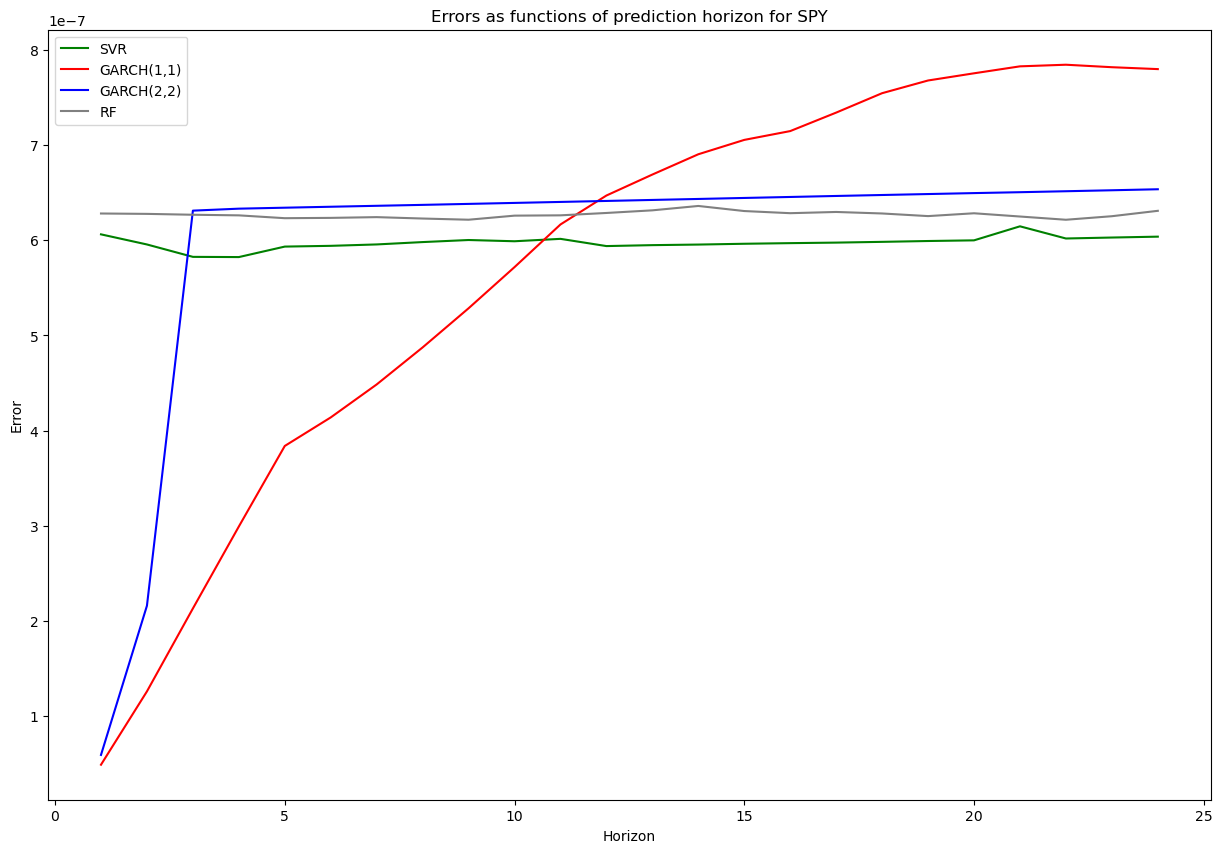

In [28]:
plt.figure(figsize=(15, 10))
plt.plot(range(1,25),err_svr,color='green', label='SVR') 
plt.plot(range(1,25),err_1,color='red', label="GARCH(1,1)") 
plt.plot(range(1,25),err_2,color='blue', label="GARCH(2,2)") 
plt.plot(range(1,25),err_rf,color='gray', label='RF') 
plt.title('Errors as functions of prediction horizon for SPY') 
plt.ylabel('Error') 
plt.xlabel('Horizon') 
plt.legend()
plt.show()

In [8]:
data_spy = pd.DataFrame()
data_spy["pred_garch11"] = pred_11
data_spy["pred_garch22"] = pred_22
data_spy['pred_svr'] = pred_svr
data_spy['pred_rf'] = pred_rf

In [9]:
true = []
sigma = realized_vol
for h  in range(1,25):
    l = int((len(sigma)-15)*0.8)
    sigma_train, sigma_test = sigma[:l], sigma[l:]   
    y_test = sigma_test[h:]
    true.append(y_test)

In [10]:
len(true[4])

611

In [11]:
data_spy["true"] = true

# Same for MOEX

In [23]:
MOEX = yf.download('IMOEX.ME', start = '2010-01-01', end='2022-1-1')

[*********************100%***********************]  1 of 1 completed


In [24]:
MOEX['Daily Return'] = MOEX['Adj Close'].pct_change(1)
returns = MOEX['Daily Return'].dropna().values
returns1 = returns[4:]
MOEX['Adj Daily Return'] = MOEX['Daily Return'] - MOEX['Daily Return'].mean()
realized_vol1 = MOEX['Adj Daily Return'].rolling(5).std().values

In [25]:
MOEX["Sigma"] = realized_vol1
MOEX.to_csv("MOEX.csv")

In [15]:
MOEX.tail(10)

,Open,High,Low,Close,Adj Close,Volume,Daily Return,Adj Daily Return
Date,,,,,,,,
2021-12-17,3725.040039,3739.590088,3696.500000,3723.270020,3723.270020,0,-0.007223,-0.007721
2021-12-20,3657.649902,3674.709961,3629.610107,3669.050049,3669.050049,0,-0.014562,-0.015060
2021-12-21,3705.330078,3713.679932,3670.159912,3693.020020,3693.020020,0,0.006533,0.006036
2021-12-22,3715.199951,3759.669922,3699.060059,3746.750000,3746.750000,0,0.014549,0.014052
2021-12-23,3745.520020,3751.370117,3691.040039,3704.600098,3704.600098,0,-0.011250,-0.011747
2021-12-24,3700.340088,3703.719971,3653.629883,3702.719971,3702.719971,0,-0.000508,-0.001005
2021-12-27,3711.770020,3742.120117,3709.189941,3740.629883,3740.629883,0,0.010238,0.009741
2021-12-28,3766.500000,3790.439941,3751.000000,3777.560059,3777.560059,0,0.009873,0.009375
2021-12-29,3756.540039,3770.090088,3727.350098,3741.070068,3741.070068,0,-0.009660,-0.010157


In [16]:
err_1 = []
err_2 = []
err_svr = []
err_rf = []

for h  in range(1,25):
    err_1.append(garch11(returns1, realized_vol1, h))
    err_2.append(garch22(returns1, realized_vol1, h))
    err_svr.append(predict_ts(realized_vol1,h))
    err_rf.append(rf_predict(realized_vol1, h))

In [17]:
eerr_1 = np.transpose(err_1)
eerr_1[1]

array([1.2347175661704386e-08, 2.8595299426579507e-07,
       2.865950824914621e-07, 2.872414950537846e-07,
       2.878820548737885e-07, 2.885206966119937e-07,
       2.8897696055353155e-07, 2.8940795463280835e-07,
       2.898400784249408e-07, 2.896152886006413e-07,
       2.8935195657898236e-07, 2.898591958857295e-07,
       2.903863900264646e-07, 2.907359390768202e-07,
       2.912293378806737e-07, 2.9183608361659507e-07,
       2.924660512395116e-07, 2.931112206909047e-07,
       2.9379222895026696e-07, 2.9445982872138695e-07,
       2.9488746202689093e-07, 2.953691816838687e-07,
       2.9586112385368777e-07, 2.9606038446994233e-07], dtype=object)

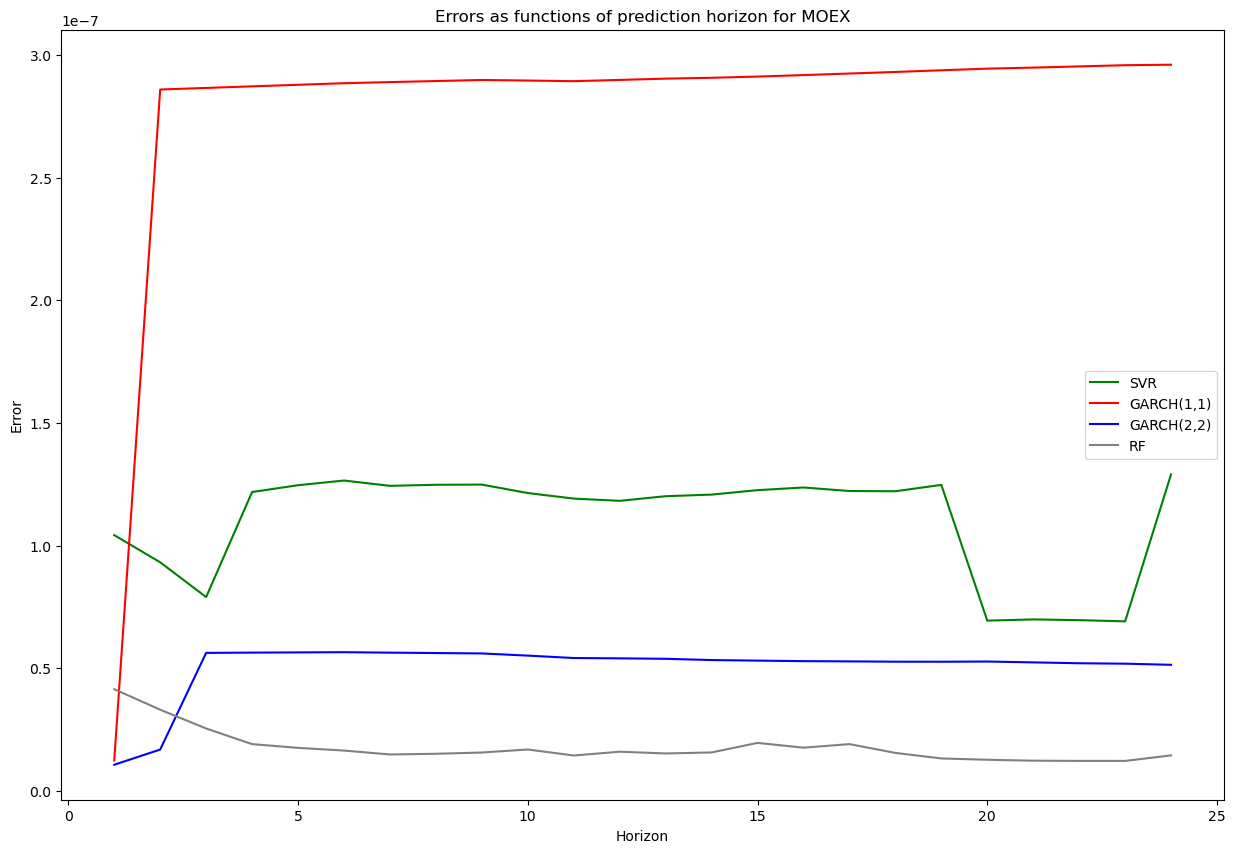

In [18]:
plt.figure(figsize=(15, 10))
plt.plot(range(1,25),np.transpose(err_svr)[1],color='green', label='SVR') 
plt.plot(range(1,25),np.transpose(err_1)[1],color='red', label="GARCH(1,1)") 
plt.plot(range(1,25),np.transpose(err_2)[1],color='blue', label="GARCH(2,2)") 
plt.plot(range(1,25),np.transpose(err_rf)[1],color='gray', label='RF') 
plt.title('Errors as functions of prediction horizon for MOEX') 
plt.ylabel('Error') 
plt.xlabel('Horizon') 
plt.legend()
plt.show()

In [19]:
data_moex = pd.DataFrame()
data_moex["pred_garch11"] = np.transpose(err_1)[0]
data_moex["pred_garch22"] = np.transpose(err_2)[0]
data_moex['pred_svr'] = np.transpose(err_svr)[0]
data_moex['pred_rf'] = np.transpose(err_rf)[0]

In [20]:
true = []
sigma = realized_vol1
for h  in range(1,25):
    l = int((len(sigma)-15)*0.8)
    sigma_train, sigma_test = sigma[:l], sigma[l:]   
    y_test = sigma_test[h:]
    true.append(y_test)

In [21]:
data_moex["true"] = true

In [22]:
data_spy.to_csv("spy_res.csv")
data_moex.to_csv("moex_res.csv")

# Same for RTS

In [19]:
rts = pd.read_csv('/Users/gosa/Desktop/ensae/stat_app/data/rts.csv',sep=';')

In [20]:
arr_ret = rts["CLOSE"].values

In [21]:
for i in range(len(arr_ret)):
    arr_ret[i] = float(arr_ret[i].replace(',','.'))
    
rts["CLOSE"] = arr_ret

In [22]:
rts['Daily Return'] = rts['CLOSE'].pct_change(1)
returns = rts['Daily Return'].dropna().values
returns2 = returns[4:]
rts['Adj Daily Return'] = rts['Daily Return'] - rts['Daily Return'].mean()
realized_vol2 = rts['Adj Daily Return'].rolling(5).std().values
rts["Sigma"] = realized_vol2
rts.to_csv("rts.csv")

In [27]:
err_1 = []
err_2 = []
err_svr = []
err_rf = []

for h  in range(1,25):
    err_1.append(garch11(returns2, realized_vol2, h))
    err_2.append(garch22(returns2, realized_vol2, h))
    err_svr.append(predict_ts(realized_vol2,h))
    err_rf.append(rf_predict(realized_vol2, h))

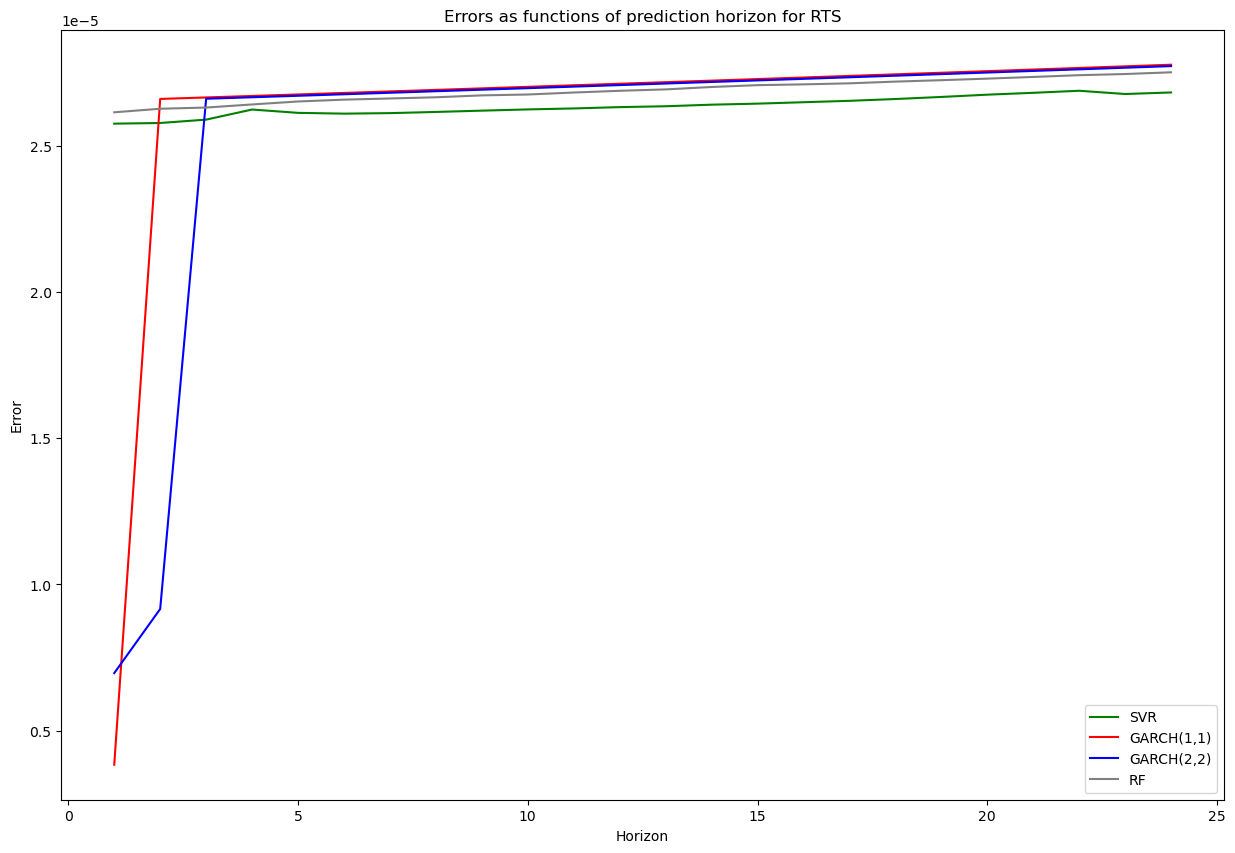

In [28]:
plt.figure(figsize=(15, 10))
plt.plot(range(1,25),np.transpose(err_svr)[1],color='green', label='SVR') 
plt.plot(range(1,25),np.transpose(err_1)[1],color='red', label="GARCH(1,1)") 
plt.plot(range(1,25),np.transpose(err_2)[1],color='blue', label="GARCH(2,2)") 
plt.plot(range(1,25),np.transpose(err_rf)[1],color='gray', label='RF') 
plt.title('Errors as functions of prediction horizon for RTS') 
plt.ylabel('Error') 
plt.xlabel('Horizon') 
plt.legend()
plt.show()

In [29]:
data_rts = pd.DataFrame()
data_rts["pred_garch11"] = np.transpose(err_1)[0]
data_rts["pred_garch22"] = np.transpose(err_2)[0]
data_rts['pred_svr'] = np.transpose(err_svr)[0]
data_rts['pred_rf'] = np.transpose(err_rf)[0]
true = []
sigma = realized_vol2
for h  in range(1,25):
    l = int((len(sigma)-15)*0.8)
    sigma_train, sigma_test = sigma[:l], sigma[l:]   
    y_test = sigma_test[h:]
    true.append(y_test)
    
data_rts["true"] = true

data_rts.to_csv("data_rts.csv")

# Export data to appropriate format

In [75]:
data_moex

,pred_garch11,pred_garch22,pred_svr,pred_rf,true
0,"[0.0034732811864467182, 0.0015103461942827456,...","[0.0027812973239389758, 0.0024918139016706204,...","[0.00036446923316624664, 0.0003772719946228775...","[1.701277377089858e-05, 3.8100070622711954e-05...","[0.0375812031297928, 0.044295751404894404, 0.0..."
1,"[4.8772030973307164e-05, 4.7008015188470335e-0...","[0.001743576568466027, 0.000762108794042265, 0...","[0.00034914218007761605, 0.0003614320801597745...","[1.718931615498615e-05, 4.628632865241779e-05,...","[0.044295751404894404, 0.03819126640890377, 0...."
2,"[4.8772030973307164e-05, 4.7008015188470335e-0...","[1.387144746353139e-05, 1.387144746353139e-05,...","[0.00033383008214608374, 0.000345480591082013,...","[1.3154751500800633e-05, 3.391756905924379e-05...","[0.03819126640890377, 0.02535264098551956, 0.0..."
3,"[4.8772030973307164e-05, 4.7008015188470335e-0...","[1.387144746353139e-05, 1.387144746353139e-05,...","[0.0004221777141612217, 0.0004312211393199253,...","[1.3976639646050058e-05, 4.25366119256472e-05,...","[0.02535264098551956, 0.026569381964306145, 0...."
4,"[4.8772030973307164e-05, 4.7008015188470335e-0...","[1.387144746353139e-05, 1.387144746353139e-05,...","[0.0004261208177462493, 0.0004352165809975831,...","[5.003929031449245e-05, 3.029418579972189e-05,...","[0.026569381964306145, 0.02895153709923178, 0...."
5,"[4.8772030973307164e-05, 4.7008015188470335e-0...","[1.387144746353139e-05, 1.387144746353139e-05,...","[0.0004289749283762027, 0.0004380367501960614,...","[4.982043111518196e-05, 4.982043111518196e-05,...","[0.02895153709923178, 0.018175042235016137, 0...."
6,"[4.8772030973307164e-05, 4.7008015188470335e-0...","[1.387144746353139e-05, 1.387144746353139e-05,...","[0.0004263866698856887, 0.00043528599742705376...","[6.675096767596392e-05, 0.0001506658007664901,...","[0.018175042235016137, 0.018334493337175038, 0..."
7,"[4.8772030973307164e-05, 4.7008015188470335e-0...","[1.387144746353139e-05, 1.387144746353139e-05,...","[0.0004268732175260911, 0.00043571844878601, 0...","[7.43826255379828e-05, 8.516322395490266e-05, ...","[0.018334493337175038, 0.016343702937233057, 0..."
8,"[4.8772030973307164e-05, 4.7008015188470335e-0...","[1.387144746353139e-05, 1.387144746353139e-05,...","[0.0004269351785298434, 0.0004356675142733759,...","[8.632671895044811e-05, 0.00011415405290486536...","[0.016343702937233057, 0.00941711285920438, 0...."
9,"[4.8772030973307164e-05, 4.7008015188470335e-0...","[1.387144746353139e-05, 1.387144746353139e-05,...","[0.0004218066237927548, 0.0004303982516494846,...","[7.48335447217927e-05, 9.323412704277839e-05, ...","[0.00941711285920438, 0.005398546320286634, 0...."


In [71]:
int_values = []
for i in range(len(data_moex["pred_svr"])):
    for j in range(len(data_moex["pred_svr"][i])):
       int_values.append(data_moex["pred_svr"][i][j][0])
    
    data_moex["pred_svr"][i] = int_values 
    int_values = []

In [72]:
int_values = []
for i in range(len(data_moex["pred_rf"])):
    for j in range(len(data_moex["pred_rf"][i])):
       int_values.append(data_moex["pred_rf"][i][j][0])
    
    data_moex["pred_rf"][i] = int_values 
    int_values = []

In [139]:
garch11_vs_svr = []
garch22_vs_svr = []
g11_vs_g22 = []
for i in range(24):
    garch11_vs_svr.append(np.around(dm_test(np.array(data_moex["true"][i]),np.array(data_moex["pred_garch11"][i]),
                    np.array(data_moex["pred_svr"][i])),4))
    garch22_vs_svr.append(np.around(dm_test(np.array(data_moex["true"][i]),np.array(data_moex["pred_garch22"][i]),
                    np.array(data_moex["pred_svr"][i])),4))
    g11_vs_g22.append(np.around(dm_test(np.array(data_moex["true"][i]),np.array(data_moex["pred_garch22"][i]),
                    np.array(data_moex["pred_garch11"][i])),4))
    

In [141]:
pd.DataFrame(np.transpose(garch11_vs_svr)).transpose()

,0,1
0,0.0,5.6848
1,0.0,6.4026
2,0.0,5.7564
3,0.0,9.3082
4,0.0,10.2988
5,0.0,12.0632
6,0.0,13.7767
7,0.0,14.1431
8,0.0,13.4542
9,0.0,12.8621


In [113]:
pd.DataFrame(np.transpose(garch11_vs_rf)).transpose()

,0,1
0,0.0131,-2.4903
1,0.0000,-5.2358
2,0.0003,-3.6770
3,0.0009,-3.3392
4,0.0000,-5.6450
5,0.0000,-5.4840
6,0.0000,-5.7052
7,0.0000,-4.9901
8,0.0002,-3.7224
9,0.0026,-3.0206


In [105]:
def dm_test(actual_lst, pred1_lst, pred2_lst, h = 1, crit="MSE", power = 2):
    # Routine for checking errors
    def error_check():
        rt = 0
        msg = ""
        # Check if h is an integer
        if (not isinstance(h, int)):
            rt = -1
            msg = "The type of the number of steps ahead (h) is not an integer."
            return (rt,msg)
        # Check the range of h
        if (h < 1):
            rt = -1
            msg = "The number of steps ahead (h) is not large enough."
            return (rt,msg)
        len_act = len(actual_lst)
        len_p1  = len(pred1_lst)
        len_p2  = len(pred2_lst)
        # Check if lengths of actual values and predicted values are equal
        if (len_act != len_p1 or len_p1 != len_p2 or len_act != len_p2):
            rt = -1
            msg = "Lengths of actual_lst, pred1_lst and pred2_lst do not match."
            return (rt,msg)
        # Check range of h
        if (h >= len_act):
            rt = -1
            msg = "The number of steps ahead is too large."
            return (rt,msg)
        # Check if criterion supported
        if (crit != "MSE" and crit != "MAPE" and crit != "MAD" and crit != "poly"):
            rt = -1
            msg = "The criterion is not supported."
            return (rt,msg)  
        # Check if every value of the input lists are numerical values
        from re import compile as re_compile
        comp = re_compile("^\d+?\.\d+?$")  
        def compiled_regex(s):
            """ Returns True is string is a number. """
            if comp.match(s) is None:
                return s.isdigit()
            return True
        return (rt,msg)
    
    # Error check
    error_code = error_check()
    # Raise error if cannot pass error check
    if (error_code[0] == -1):
        raise SyntaxError(error_code[1])
        return
    # Import libraries
    from scipy.stats import t
    import collections
    import pandas as pd
    import numpy as np
    
    # Initialise lists
    e1_lst = []
    e2_lst = []
    d_lst  = []
    
    # convert every value of the lists into real values
    actual_lst = pd.Series(actual_lst).apply(lambda x: float(x)).tolist()
    pred1_lst = pd.Series(pred1_lst).apply(lambda x: float(x)).tolist()
    pred2_lst = pd.Series(pred2_lst).apply(lambda x: float(x)).tolist()
    
    # Length of lists (as real numbers)
    T = float(len(actual_lst))
    
    # construct d according to crit
    if (crit == "MSE"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append((actual - p1)**2)
            e2_lst.append((actual - p2)**2)
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)
    elif (crit == "MAD"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append(abs(actual - p1))
            e2_lst.append(abs(actual - p2))
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)
    elif (crit == "MAPE"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append(abs((actual - p1)/actual))
            e2_lst.append(abs((actual - p2)/actual))
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)
    elif (crit == "poly"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append(((actual - p1))**(power))
            e2_lst.append(((actual - p2))**(power))
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)    
    
    # Mean of d        
    mean_d = pd.Series(d_lst).mean()
    
    # Find autocovariance and construct DM test statistics
    def autocovariance(Xi, N, k, Xs):
        autoCov = 0
        T = float(N)
        for i in np.arange(0, N-k):
              autoCov += ((Xi[i+k])-Xs)*(Xi[i]-Xs)
        return (1/(T))*autoCov
    gamma = []
    for lag in range(0,h):
        gamma.append(autocovariance(d_lst,len(d_lst),lag,mean_d)) # 0, 1, 2
    V_d = (gamma[0] + 2*sum(gamma[1:]))/T
    DM_stat=V_d**(-0.5)*mean_d
    harvey_adj=((T+1-2*h+h*(h-1)/T)/T)**(0.5)
    DM_stat = harvey_adj*DM_stat
    # Find p-value
    p_value = 2*t.cdf(-abs(DM_stat), df = T - 1)
    
    # Construct named tuple for return
    dm_return = collections.namedtuple('dm_return', 'DM p_value')
    
    rt = dm_return(DM = DM_stat, p_value = p_value)
    
    return [p_value,DM_stat]